In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from utils import *
from kalman_utils import *

# Towards practical Bayesian inversion systems

What we have seen in previous notebooks is that it makes sense to constrain the inversion with a prior. We have seen that this results in better retrievals, characterised by smaller uncertainties, so it appears like an obvious and eminently great idea... Obviously, this is well-known and people have exploited it like forever. The most famous method is the Kalman filter, which is a re-arranging of the equations we have developed above into a super elegant algorithm.

## The Kalman filter

In the Kalman filter, we assume that we have a *"state"*, which is the pdf of our parameters. We assume that this pdf is multivariate normal, with mean $\vec{f}_{a}^{k}$ and covariance $\mathbf{P}_{a}^{k}$ at time $k$. Going form $t=k\longrightarrow k+1$, we have that we have a linear dynamic model that propagates the state vector and its associated uncertainty. Our extra bit of uncertainty is now stored in a covariance matrix $\mathbf{Q}^{k}$
$$
\begin{align}
\vec{f}_{f}^{k+1} &= \mathbf{M}\cdot \vec{f}_{f}^{k} \\
\mathbf{P}_{f}^{k+1} &= \mathbf{M}\cdot \mathbf{P}_{f}^{k+1} + \mathbf{Q}^{k}\\
\end{align}
$$

In our previous case, the model $\mathbf{M}$ was just the identity matrix (we assume no dynamics), but you can have any linear or locally linear model. Now, to bring in the observations we have our likelihood equation from above. Combining these two, we start by defining a so called "Kalman gain", $\mathbf{G}$:

$$
\mathbf{G}^{k+1}=\mathbf{P}_{f}^{k}\mathbf{K}^{k+1}\cdot\left[\mathbf{K}^{k+1} \mathbf{P}_{f}^{k} \mathbf{K}^{\top\;k+1}  + \mathbf{C}_{obs}^{k+1}   \right]^{-1}
$$

Then, the update of the state in time $k+1$ is
$$
\vec{f}_{a}^{k+1} = \vec{f}_{f}^{k} + \mathbf{G}^{k+1}\left[\mathbf{K}^{k}\cdot\vec{f}_{f}^{k+1} - \vec{rho}^{k+1}   \right],
$$

and there's a similar  update equation for the "analysis" covariance matrix, but I can't be bothered to write it up.

All this looks quite clever:

1. You propagate your state from one time to the next with a linear model. The model is incorrect, so you account for that by inflating the uncertainty.
2. You then use that propagated state as a prior to invert the observations
3. As everything is nice and linear, there are analytic expressions that allow you to do that easily.

### Application to linear BRDF kernel modelling

We will use the Kalman filter to produce a gap-free kernel weight dataset with quantified uncertainty. Some ingredients:

* We will use an identity dynamic model: this means that $\mathcal{M}$ is an identity matrix, which means that between e.g. days, we expect no change in the surface parameters
* We will assume some error on the dynamic model. We expect more uncertainty in the isotropic rather than in the geometric and volumetric weights, as we have seen most of the dynamics go on the isotropic.
* We will start with some fairly uncertainty estimate of the state. Feel free to change it and see what happens!
* We will assume an uncertainty (e.g. standard deviation) of 0.01 in the reflectance data.



In [2]:
doys, qa, vza, sza, raa, rho, kern, n_obs = prepare_data()

# Dynamic model related parameters
A = np.eye(3) # Dynamic model is identity!
Q = np.eye(3)*np.array([0.005, 1e-6, 1e-6])  # Dynamic model uncertainty

# Starting point related parameters
f = np.array([0.5, 0.05, 0.05]) # Prior mean for f0, f1 and f2
P = np.eye(3)*np.array([0.001, 0.001, 0.001]) # Uncertainty in prior estimate

# Uncertainty in observations
R = np.eye(1)*(0.01**2)

kf_m, kf_P, innovations = kalman_filter(f, P, doys, qa, rho, kern, R, A, Q)

Let's plot the solution. We will also plot the missing observations in the time series as vertical dark grey lines:

Text(0.5, 0, 'Day of year [d]')

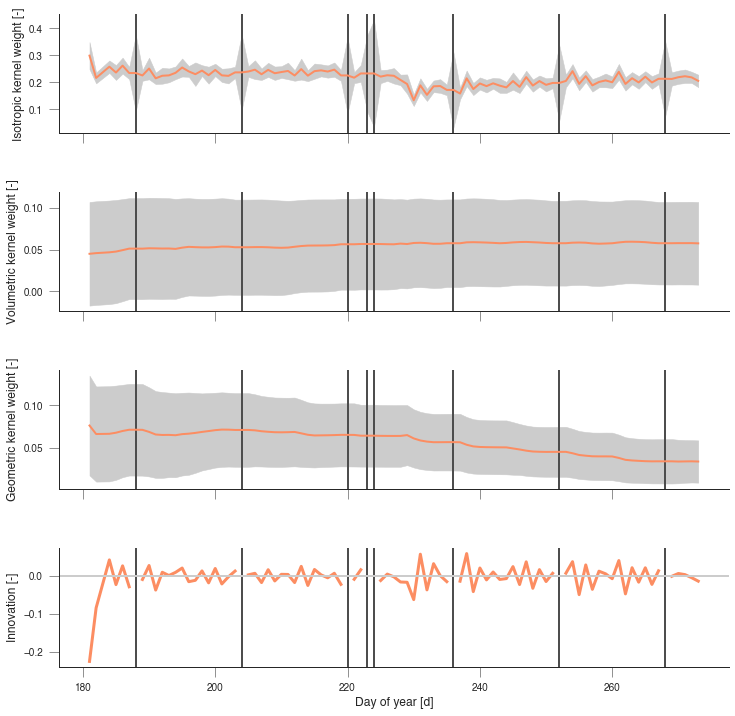

In [3]:
fig, axs = plt.subplots(nrows=4, ncols=1,  sharex=True, figsize=(12, 12))
axs = axs.flatten()

for i in range(4):
    [axs[i].axvline(z, c="0.3", lw=2) for z in doys[qa==0]]

for i in range(3):
    sigma = np.array([np.sqrt(u.diagonal()[i]) for u in kf_P])
    axs[i].fill_between(doys, kf_m[:, i] - 1.96*sigma,
                kf_m[:, i] + 1.96*sigma, color="0.8")
    axs[i].plot(doys, kf_m[:, i], '-', lw=2)
axs[3].plot(doys, innovations, '-', lw=3)
axs[3].axhline(0, c="0.8", lw=2)
axs[0].set_ylabel("Isotropic kernel weight [-]")
axs[1].set_ylabel("Volumetric kernel weight [-]")
axs[2].set_ylabel("Geometric kernel weight [-]")
axs[3].set_ylabel("Innovation [-]")
axs[3].set_xlabel("Day of year [d]")



Let's focus at the start of the time series: we can see that over the first few days, the innoviations are all drifiting up, as the filter is being updated with new data and leaving behind the very inaccurate starting point. Around day 187 or so, the solution is stabilised, and the filter then tracks the dynamics. In the Day 228 and subsequent, we can see that the innovations jump around quite a bit, as the filter starts tracking the abrupt change of the fire and the subsequent recovery dynamics.

We can also see that the isotropic uncertainty grows significantly when the filter is in effect interpolating missing observations. It's a way of telling the us that it's making it all up and that we should be aware of it.

The other obvious trend (particularly visible in the geometric kernel weight) is the shrinking of uncertainty as the filter progresses. The filter is learning from the past observations, so the more data it "chomps", the more certain it is about the state.

We can think that we can also run the filter backwards (e.g. starting from the end of the time series)

Text(0.5, 0, 'Day of year [d]')

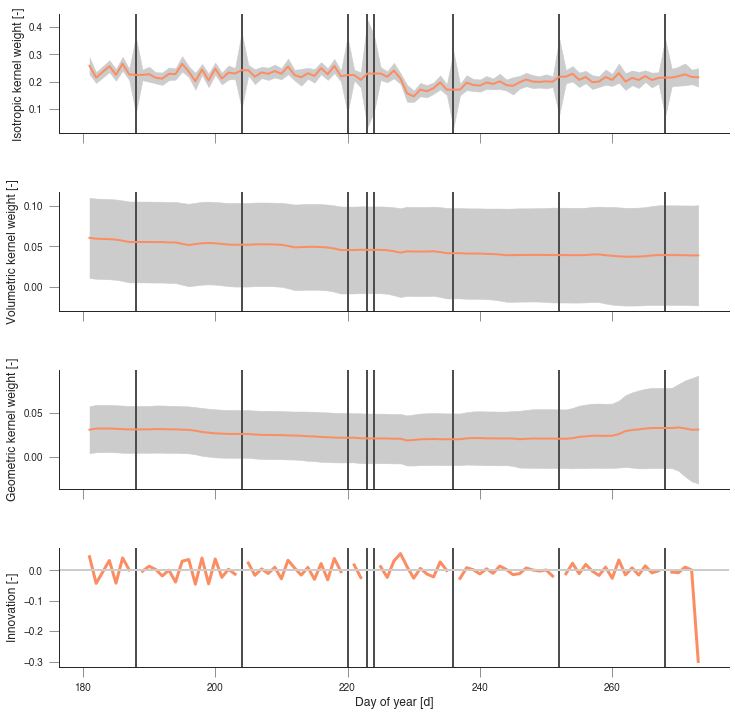

In [4]:
doys, qa, vza, sza, raa, rho, kern, n_obs = prepare_data()

# Dynamic model related parameters
A = np.eye(3) # Dynamic model is identity!
Q = np.eye(3)*np.array([0.005, 1e-6, 1e-6])  # Dynamic model uncertainty

# Starting point related parameters
f = np.array([0.5, 0.05, 0.05]) # Prior mean for f0, f1 and f2
P = np.eye(3)*np.array([0.001, 0.001, 0.001]) # Uncertainty in prior estimate

# Uncertainty in observations
R = np.eye(1)*(0.01**2)

kfr_m, kfr_P, rinnovations = kalman_filter(f, P, doys, qa, rho, kern, R, A, Q,
                                        backwards=True)
fig, axs = plt.subplots(nrows=4, ncols=1,  sharex=True, figsize=(12, 12))
axs = axs.flatten()

for i in range(4):
    [axs[i].axvline(z, c="0.3", lw=2) for z in doys[qa==0]]

for i in range(3):
    sigma = np.array([np.sqrt(u.diagonal()[i]) for u in kfr_P])
    axs[i].fill_between(doys[::-1], kfr_m[:, i] - 1.96*sigma,
                kfr_m[:, i] + 1.96*sigma, color="0.8")
    axs[i].plot(doys[::-1], kfr_m[:, i], '-', lw=2)
axs[3].plot(doys[::-1], rinnovations, '-', lw=3)
axs[3].axhline(0, c="0.8", lw=2)
axs[0].set_ylabel("Isotropic kernel weight [-]")
axs[1].set_ylabel("Volumetric kernel weight [-]")
axs[2].set_ylabel("Geometric kernel weight [-]")
axs[3].set_ylabel("Innovation [-]")
axs[3].set_xlabel("Day of year [d]")



We see effects that can be explained as in the previous example. We also see that the fire is now an increase in the innovations rather than a decrease! And we can also see that the filter is very succesful at tracking the post-fire dynamics (once it "forgets" its starting guess). So in the "forward" example, for time $k$ we use all observations from $k=1$ until $k-1$, and in the backward example, the estimate comes from all observations from $k=N_{obs}$ up to $k+1$. These are two independent datasets, so we can think of combining both estimates. As statistics are normal, this is fairly simple.

<div>
<img style="float: right;" src="http://www.maquituls.es/noticias/wp-content/uploads/2016/05/lija-para-madera.jpg" width="200"/>
</div>

## The Kalman Smoother

The Kalman smoother is the the realisation of the `backward+forwards=success` model. In the smoother, you use both information from the past and the future to constrain the present, and as such, you get a better estimate (lower uncertainties, usually less jitter of the mean). There are different implementations of this (the most obvious one is the one pointed out in the previous paragraph: run forwards, run backwards and combine them). Perhaps the most efficient one is the RTS implementation: it doesn't need to store the data or the obervation operator. Once the Kalman filter is run, its solution forms the basis of the RTS smoother.

Text(0.5, 0, 'Day of year [d]')

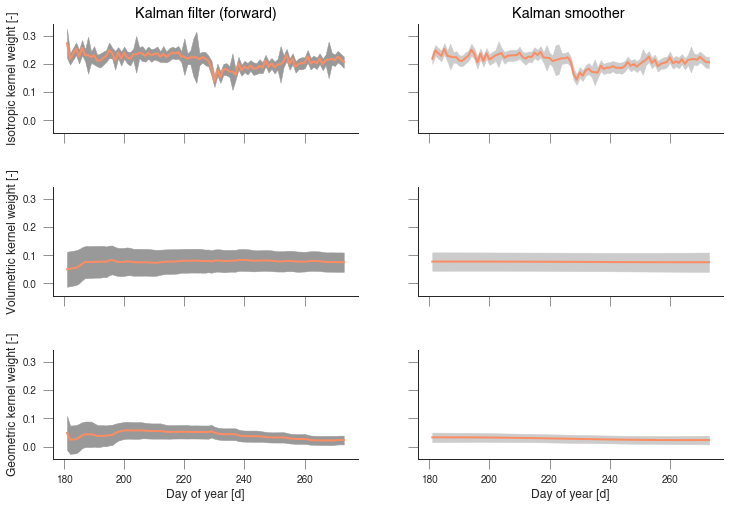

In [5]:

# Starting point related parameters
f = np.array([0.25, 0.05, 0.05]) # Prior mean for f0, f1 and f2
P = np.eye(3)*np.array([0.01, 0.001, 0.001]) # Uncertainty in prior estimate
# Dynamic model related parameters
A = np.eye(3) # Dynamic model is identity!
Q = np.eye(3)*np.array([0.001, 1e-6, 1e-6])  # Dynamic model uncertainty
# Uncertainty in observations
R = np.eye(1)*(0.01**2)

kf_m, kf_P, innovations = kalman_filter(f, P, doys, qa, rho, kern, R, A, Q)
f = kf_m[-1, :]
P = kf_P[-1, :, :]
rts_m, rts_P = kalman_smoother(f, P, kf_m, kf_P, A, Q)
fig, axs = plt.subplots(nrows=3, ncols=2,  sharex=True, sharey=True, figsize=(12, 8))

for i in range(3):
    sigma = np.array([np.sqrt(u.diagonal()[i]) for u in kf_P])
    axs[i, 0].fill_between(doys, kf_m[:, i] - 1.96*sigma,
                kf_m[:, i] + 1.96*sigma, color="0.6")
    axs[i, 0].plot(doys, kf_m[:, i], '-', lw=2)

    sigma = np.array([np.sqrt(u.diagonal()[i]) for u in rts_P])
    axs[i, 1].fill_between(doys, rts_m[:, i] - 1.96*sigma,
                rts_m[:, i] + 1.96*sigma, color="0.8")
    axs[i, 1].plot(doys, rts_m[:, i], '-', lw=2)
    
axs[0, 0].set_title("Kalman filter (forward)")
axs[0, 1].set_title("Kalman smoother ")
axs[0, 0].set_ylabel("Isotropic kernel weight [-]")
axs[1, 0].set_ylabel("Volumetric kernel weight [-]")
axs[2, 0].set_ylabel("Geometric kernel weight [-]")
axs[2, 0].set_xlabel("Day of year [d]")
axs[2, 1].set_xlabel("Day of year [d]")


So that's interesting. We can clearly see that the smoother is making kernel weights great again. It is paticularly remarkable in the geometric and volumetric, where the solution of the smoother suggests a single value for the entire series, with a more or less comparable uncertainty. The filter has a typical funnel like uncertainty behaviour. In all weights, we can see that combining forward and backward passes via the smoother results in decreased uncertainty: roughly, the smoother solution is characterised by an uncertainty around 90, 80 and 60% of the filter uncertainty, although this decrease will be larger at the start of the series.

<div>
<img style="float: right;" src="https://www.breadwig.com/wp-content/uploads/2018/05/elephant-cartoon-comic-wacky-character-silly-doodle-funny-cute-breadwig.com-001586.jpg" width="250"/>
</div>

## The elphant in the room: discontinuities!

Throughout the previous example, we have looked at ways to bring information from different times to the current time to help constrain our retrievals. Clearly, all this works well if there is some form of slow dynamics in the surface, but results in oversmoothing of sharp/abrupt changes, such as the fire (if you aren't bored to death of *that* fire, I don't know what will make you). If you are interesting in monitoring disturbance other methods are required, methods that detect the abrupt change, and reduce the temporal linkage between the pre- and post-change reflectances.